<a href="https://colab.research.google.com/github/Arabasma/ML-and-NLP-Projects/blob/main/TP_App_renforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Prédiction

In [ ]:
import base
import numpy as np

## Question 1

> Création d'un environement Maze



In [ ]:
env = base.Maze()

ns = env.get_nb_states()
na = env.get_nb_actions()


> Création d'une politique en appliquant le principe suivant : dans chaque état appliquer les probabilités d'actions {W: 0.1, S:0.4, E:0.4, N:0.1}

In [ ]:
p=[]
for i in range(ns):
  p.append([0.1, 0.4, 0.4, 0.1])

p

[[0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1],
 [0.1, 0.4, 0.4, 0.1]]

## Question 2


> IPE



In [ ]:
# Ecrire une fonction calculant Q en fonction de V
def compute_q(values, env, gamma):
    return np.sum(env.p()*(env.r() + gamma * values[np.newaxis, np.newaxis, :]), axis=2)

# Implémenter IPE (évaluation d'une politique)
def ipe(pi, env, gamma, epsilon=0.01):
    v = np.zeros((env.get_nb_states()))
    q = compute_q(v, env, gamma)
    nv = np.sum(pi * q, axis=1)
    delta = np.sum(np.abs(nv-v))

    while delta > epsilon:
        v = nv
        q = compute_q(v, env, gamma)
        nv = np.sum(pi * q, axis=1)
        delta = np.sum(np.abs(nv-v))

    return nv


ipe_= ipe(p, env, 0.7)
ipe_

array([ 39.81228759, 100.22612054, 222.71570143,   0.        ,
        22.05674576,   0.        , 143.24961763,   0.        ,
        41.25325582, 123.70727393, 276.86540895,   0.        ,
         7.80127379,   0.        , 645.20084027,   0.        ])


> Monte-Carlo pour la prédiction



In [ ]:
def monte_carlo_prediction(policy, env, gamma, nb_episodes):

    nba = env.get_nb_actions()
    nbs= env.get_nb_states()

    v = np.zeros(nbs)
    n = np.zeros(nbs)

    for ne in range(nb_episodes):
        state = env.reset()
        episode = []
        while not env.is_final(state): #créer les épisodes
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            episode.append([state, action, r, nvstate])
            state = nvstate

        g = 0 # retour
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s] += 1
            v[s]= v[s]+(1/n[s]) * (g- v[s])


    return v

> TD(0)

In [ ]:
def TD0(policy, env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    nbs= env.get_nb_states()

    v = np.zeros(nbs)

    for ne in range(nb_episodes):
        state = env.reset()
        episode = []
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, final, _ = env.step(action)
            episode.append([state, action, r, nvstate])

            if final:
                target = r # TD target
            else:
                target = r + gamma * v[nvstate]
            #Calcul de V[s]
            v[state] += alpha * (target - v[state])

            state = nvstate


    return v

> Calculer l'erreur de prédiction entre les vecteurs de valeurs calculés avec (Monte-Carlo et TD0) et le vecteur de valeurs produit par IPE, en fonction du nombre d'épisodes effectués

In [ ]:
errors_MC_ipe=[]
errors_TD_ipe=[]
#calculer l'erreur de monte carlo et TD0 en faisant varier le nombre d'épisodes
episodes= [10, 20, 50, 100, 200, 500, 750, 1000, 1500, 2000, 3500, 5000, 6000, 7000, 8500, 10000] #les différents nombres d'épisodes testées
for i in episodes:
  errors_MC_ipe.append(np.sqrt(np.sum(np.square((monte_carlo_prediction(p, env, 0.7, i)- ipe_)))))
  errors_TD_ipe.append(np.sqrt(np.sum(np.square(((TD0(p, env, 0.7, 0.1, i)- ipe_))))))

> Evaluation graphique

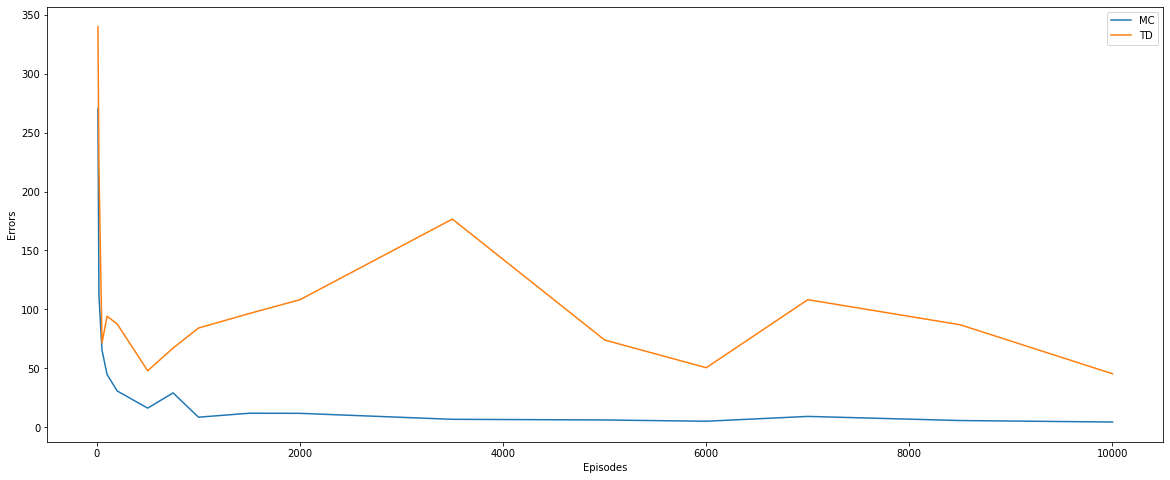

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#tracer le graphe des erreurs de TD0 et MC en fonction du nombre d'épisodes
figure(figsize=(20,8))
plt.plot(episodes, errors_MC_ipe, label="MC")
plt.plot(episodes, errors_TD_ipe, label= "TD")
plt.legend(loc='best')
plt.xlabel("Episodes")
plt.ylabel("Errors")
plt.show()




> Interprétation : TD(0) et MC on des évaluations avec des taux d'erreurs similaires pour un nombre assez petit d'épisodes mais au fur et à mesure que le nombre d'épisodes accroit c'est MC qui a le plus petit taux d'erreur en comparaison avec TD(0)





## Question 3

> n-steps TD(0)

In [ ]:
def TD0_nsteps(policy, env, gamma, alpha, nb_episodes,n):
    nba = env.get_nb_actions()
    nbs= env.get_nb_states()

    v = np.zeros(nbs)

    for ne in range(nb_episodes):
        state = env.reset()
        episode = []
        retour_trace=[]

        i = 0 #i est t
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, final, _ = env.step(action)
            episode.append([state, action, r, nvstate])
            retour_trace.append(r)
            if(i >= n): # dés qu'on arrive à t=n on peut commencer les màj des valeurs V[S]
              if final:
                 target = r
              else:
                target = 0 # G(t)
                for j in range(1,n):
                  target += retour_trace[i-n+j] * gamma**(i-n+j-1)
                  target += v[state]* gamma**n
              state_prec = episode[i-n][0] # recupérer indice de l'état dans lequel l'agent était à l'instant i-n
              v[state_prec] += alpha * (target - v[state])  #MAJ du v[s] à t+n
            state = nvstate
            i +=1

    return v

> TD(lambda)

In [ ]:
def TD_lamba(policy, env, gamma, alpha, nb_episodes,lamb):
    nba = env.get_nb_actions()
    nbs= env.get_nb_states()
    eligibility = np.zeros(nbs)


    v = np.zeros(nbs)

    for ne in range(nb_episodes):
        state = env.reset()
        episode = []

        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, final, _ = env.step(action)
            episode.append([state, action, r, nvstate])

            # Mise à jour de l'éligibité pour tous les états
            eligibility *= lamb * gamma
            eligibility[state] += 1.0 # ajouter 1 pour l'état courant
            # calculer l'erreur td et mettre à jour V[s] selon l'éligibilité
            td_error = r + gamma * v[nvstate] - v[state]
            v = v + alpha * td_error * eligibility
            state = nvstate


    return v

> Calculer l'erreur de prédiction entre les vecteurs de valeurs calculés avec ( 2steps TD, 5steps TD, 10steps TD et TD(lambda) ) et le vecteur de valeurs produit par IPE, en fonction du nombre d'épisodes effectués

In [ ]:
errors_TD_2_ipe=[]
errors_TD_5_ipe=[]
errors_TD_10_ipe=[]
errors_TD_lambda_ipe=[]
#calculer l'erreur de TD(n) avec n=2,5,10 et TD(lambda) en faisant varier le nombre d'épisodes
episodes= [10, 20, 50, 100, 200, 500, 750, 1000, 1500, 2000, 3500, 5000, 6000, 7000, 8500, 10000] #les différents nombres d'épisodes testées
for i in episodes:
  errors_TD_2_ipe.append(np.sqrt(np.sum(np.square(((TD0_nsteps(p, env, 0.7, 0.1, i, 2)- ipe_))))))
  errors_TD_5_ipe.append(np.sqrt(np.sum(np.square(((TD0_nsteps(p, env, 0.7, 0.1, i, 5)- ipe_))))))
  errors_TD_10_ipe.append(np.sqrt(np.sum(np.square(((TD0_nsteps(p, env, 0.7, 0.1, i, 10)- ipe_))))))
  errors_TD_lambda_ipe.append(np.sqrt(np.sum(np.square(((TD_lamba(p, env, 0.7, 0.1, i, 0.5)- ipe_))))))

> Les graphes d'évaluation

Text(0, 0.5, 'Errors')

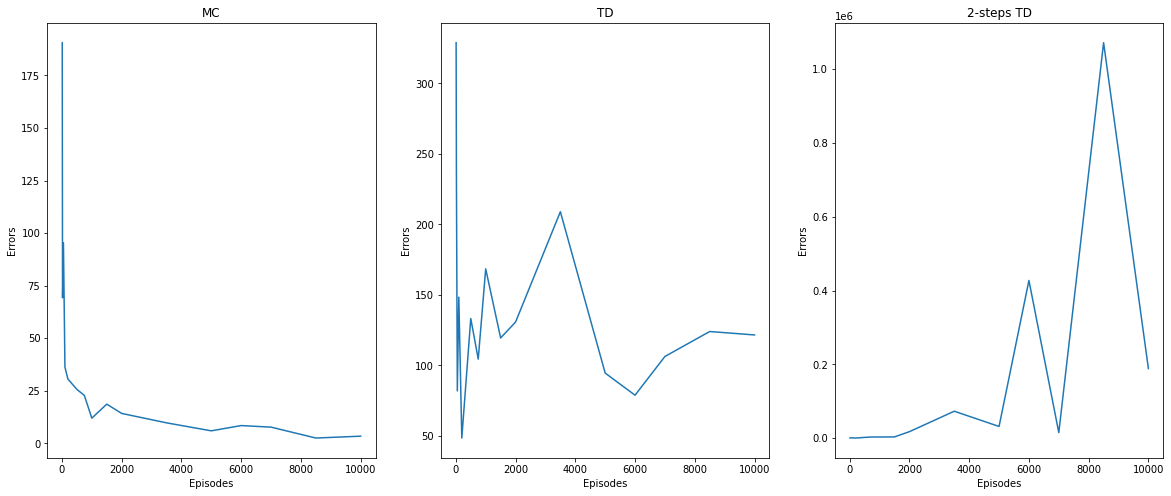

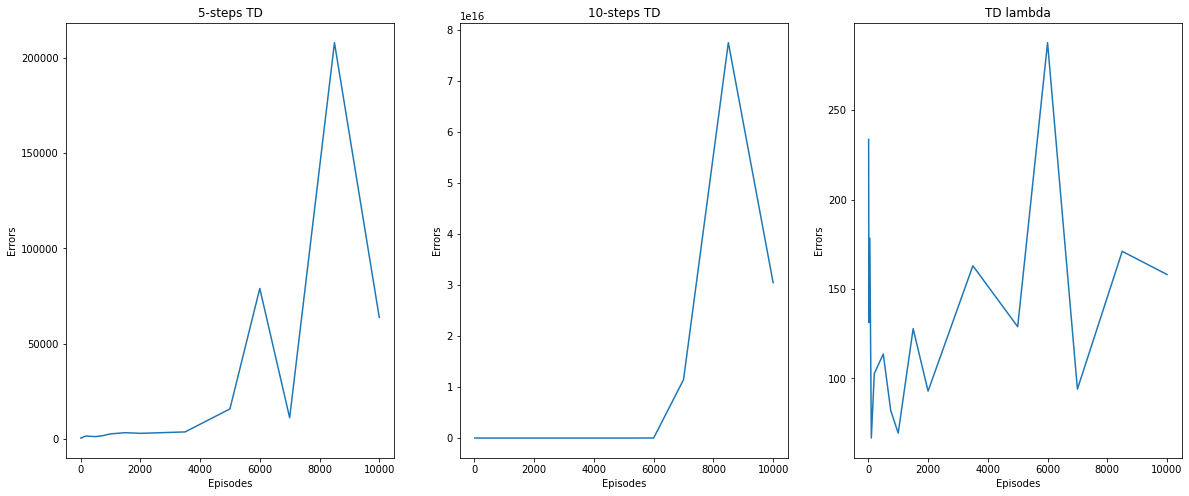

In [ ]:
plt.subplots(1,3,figsize=(20,8))
plt.subplot(1, 3, 1)
plt.plot(episodes, errors_MC_ipe)
plt.title("MC")
plt.xlabel("Episodes")
plt.ylabel("Errors")

plt.subplot(1, 3, 2)
plt.plot(episodes, errors_TD_ipe)
plt.title("TD")
plt.xlabel("Episodes")
plt.ylabel("Errors")

plt.subplot(1, 3, 3)
plt.plot(episodes, errors_TD_2_ipe)
plt.title("2-steps TD")
plt.xlabel("Episodes")
plt.ylabel("Errors")


plt.subplots(1,3,figsize=(20,8))
plt.subplot(1, 3, 1)
plt.plot(episodes, errors_TD_5_ipe)
plt.title("5-steps TD")
plt.xlabel("Episodes")
plt.ylabel("Errors")

plt.subplot(1, 3, 2)
plt.plot(episodes, errors_TD_10_ipe)
plt.title("10-steps TD")
plt.xlabel("Episodes")
plt.ylabel("Errors")

plt.subplot(1, 3, 3)
plt.plot(episodes, errors_TD_lambda_ipe)
plt.title("TD lambda")
plt.xlabel("Episodes")
plt.ylabel("Errors")

> Interprétation : L'évaluation 2-step TD et 10-step TD sont les évaluations les plus proches de l'IPE. L'évaluation avec MC se rapproche de l'IPE lorsque le nombre d'épisodes accroit, aux contraires des autres  évaluations qui sont plus proches de l'IPE lorsque le nombres d'épisodes est petit (entre 0 et 2000 dans la plupart des cas).




#Excercice 2: Contrôle




In [ ]:
import base
import math
import td_rl
import td_mdp_ex4
import numpy as np
from matplotlib import pyplot as plt


##Fonctions

In [ ]:
def ep(T,t,epsilonI):
  if t <= T:
    epsilon=epsilonI
  else:
    epsilon= epsilonI/math.sqrt(t-T)
  return epsilon


In [ ]:
def egreedy_policy(qvalues, epsilon):
    nbactions = qvalues.shape[1]
    policy = np.ones(qvalues.shape) * epsilon /nbactions
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] += 1 - epsilon
    return policy

In [ ]:
def greedy_policy(qvalues):
    policy = np.zeros(qvalues.shape)
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] = 1
    return policy

In [ ]:
def egreedy_decision(qvalues, state, epsilon):
    if np.random.rand()<epsilon:
        return np.random.randint(0, qvalues.shape[1])
    else:
        return np.argmax(qvalues[state])

In [ ]:
def greedy_decision(qvalues, state):
    return np.argmax(qvalues[state])

In [ ]:
def monte_carlo(env, gamma, nb_episodes):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    n = np.zeros((env.get_nb_states(), nba))

    policy = np.ones((env.get_nb_states(), nba)) / nba
    tab=[]

    for ne in range(nb_episodes):
        epsilon= ep(T, ne, epsilon_I)
        state = env.reset()
        episode = []
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            episode.append([state, action, r, nvstate])
            state = nvstate
        tab.append(episode)


        g = 0 # retour
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s, a] += 1
            q[s, a] += (g - q[s,a])/n[s, a]

        policy = egreedy_policy(q, epsilon)

    return q, tab

In [ ]:
def sarsa(env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))

    tab=[]

    for ne in range(nb_episodes):
        epsilon= ep(T, ne, epsilon_I)
        episode = []
        state = env.reset()
        action = egreedy_decision(q, state, epsilon)
        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)
            nvaction = egreedy_decision(q, nvstate, epsilon)

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]

            q[state, action] += alpha * (target - q[state, action])

            state = nvstate
            action = nvaction
            episode.append([state, action, r, nvstate])

        tab.append(episode)


    return q, tab


In [ ]:
def qlearning(env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    tab=[]

    for ne in range(nb_episodes):
        epsilon= ep(T, ne, epsilon_I)
        episode = []
        state = env.reset()
        while not env.is_final(state):
            action = egreedy_decision(q, state, epsilon)
            nvstate, r, final, _ = env.step(action)

            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])

            q[state, action] += alpha * (target - q[state, action])

            state = nvstate
            episode.append([state, action, r, nvstate])
        tab.append(episode)

    return q, tab

In [ ]:
###Calculer le nombre d'action par épisode

def calculer_actions(epis) :
  nb_actions=[]
  for i in epis:
    nb_actions.append(len(i))
  return nb_actions


In [ ]:
def calculer_gain_total(epis) :
  gain_total_episode=[]
  for i in epis:
    tot=0
    for j in i :
      tot= tot + j[2]
    gain_total_episode.append(tot)
  return gain_total_episode


In [ ]:
def softmax_policy (qvalues, T) :
  enum = np.exp(qvalues/T)
  denom = np.sum(np.exp(qvalues/T), axis=1).reshape(-1,1)
  result = enum / denom
  return result

In [ ]:
def softmax_decision (qvalues,state, T) :
  policy = softmax_policy(qvalues, T)
  nba = qvalues.shape[1]
  return np.random.choice(nba, p=policy[state])

In [ ]:
def monte_carlo_soft(env, gamma, nb_episodes):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    n = np.zeros((env.get_nb_states(), nba))

    policy = softmax_policy(q, T)  #np.ones((env.get_nb_states(), nba)) / nba
    tab=[]

    for ne in range(nb_episodes):
        state = env.reset()
        episode = []
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            episode.append([state, action, r, nvstate])
            state = nvstate
        tab.append(episode)


        g = 0 # retour
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s, a] += 1
            q[s, a] += (g - q[s,a])/n[s, a]
    return q, tab

In [ ]:
def sarsa_soft(env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    tab=[]
    for ne in range(nb_episodes):
        episode = []
        state = env.reset()
        action = softmax_decision(q, state, T)
        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)
            nvaction = softmax_decision(q, state, T)

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]

            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            action = nvaction
            episode.append([state, action, r, nvstate])

        tab.append(episode)


    return q, tab

In [ ]:
def qlearning_soft(env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    tab=[]

    for ne in range(nb_episodes):
        episode = []
        state = env.reset()
        while not env.is_final(state):
            action = softmax_decision(q, state,T)
            nvstate, r, final, _ = env.step(action)

            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])

            q[state, action] += alpha * (target - q[state, action])

            state = nvstate
            episode.append([state, action, r, nvstate])
        tab.append(episode)

    return q, tab

In [ ]:
def sarsa_greedy(env, gamma, alpha, nb_episodes):
    #initialiser q avec des valeurs Rmax/ (1-gamma)
    rmax  = np.max(env.r())
    quat =  rmax / (1-gamma)
    q = np.ones((env.get_nb_states(), env.get_nb_actions())) * quat
    tab=[]
    for ne in range(nb_episodes):
        episode = []
        state = env.reset()
        action = greedy_decision(q, state)
        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)
            nvaction = greedy_decision(q, state)

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]

            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            action = nvaction
            episode.append([state, action, r, nvstate])

        tab.append(episode)


    return q, tab

In [ ]:
def qlearning_greedy(env, gamma, alpha, nb_episodes):
    #initialiser q avec des valeurs Rmax/ (1-gamma)
    rmax  = np.max(env.r())
    quat =  rmax / (1-gamma)
    q = np.ones((env.get_nb_states(), env.get_nb_actions())) * quat
    tab=[]

    for ne in range(nb_episodes):
        episode = []
        state = env.reset()
        while not env.is_final(state):
            action = greedy_decision(q, state)
            nvstate, r, final, _ = env.step(action)

            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])

            q[state, action] += alpha * (target - q[state, action])

            state = nvstate
            episode.append([state, action, r, nvstate])
        tab.append(episode)

    return q, tab

##Question1

> Nous allons appliquer, dans cette section, les 3 algorithmes (MC, SARSA, QL) avec egreedy et des configuration différente de epsilon et de T.

> Nous affichons à chaque exécution le nombre d'actions exécutées.

###Test 1: T=5, epsilon_0= 1

In [ ]:
T= 5
epsilon_I= 1

####MC

In [ ]:
e= base.Maze()

In [ ]:
q,epi =monte_carlo(e, 0.9, 10)

In [ ]:
q

array([[  70.79273874,   76.37662358,  123.11641257,   85.55214939],
       [  73.38081682,   44.25784015,  244.15874535,  112.533744  ],
       [ 135.42282626,  340.07154438,  400.        ,  218.50093101],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [  47.09431263,   85.08483252,   84.8966903 ,  127.7715426 ],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [ 309.07916485,  386.38927153,  171.12916546,  250.40146828],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [ 230.36323967,   86.51929055,  133.67347681,   97.84688593],
       [  31.44772168,   40.68443732,  221.40455752,   34.4651079 ],
       [ 109.53809227,  900.        ,  148.74770727,  175.3726093 ],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [ 124.09493408,   47.32307345,  252.56467805,  129.46035164],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.      

In [ ]:
epi

[[[0, 2, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 1, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 3, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 2, 0.0, 9],
  [9, 0, 0.0, 8],
  [8, 3, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 0, 0.0, 8],
  [8, 0, 0.0, 8],
  [8, 2, 0.0, 9],
  [9, 0, 0.0, 8],
  [8, 1, 0.0, 12],
  [12, 1, 0.0, 12],
  [12, 1, 0.0, 12],
  [12, 3, 0.0, 8],
  [8, 3, 0.0, 4],
  [4, 3, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 1, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 0, 0.0, 8],
  [8, 0, 0.0, 8],
  [8, 3, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 2, 0.0, 9],
  [9, 3, 0.0, 9],
  [9

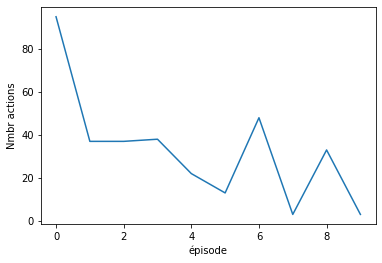

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))



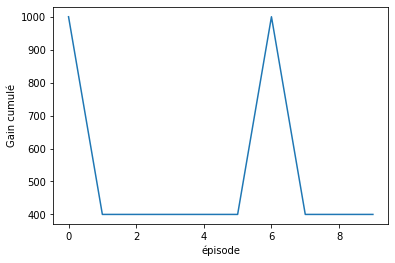

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))


> Nous remarquons que seulement deux épisodes parmi 10 qui convergent vers la solution optimale (reward = 1000).

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

####SARSA

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 10)

In [ ]:
p= greedy_policy(q)

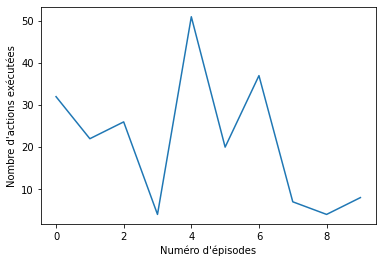

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

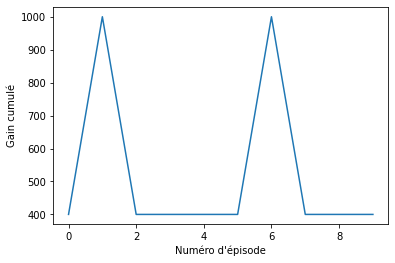

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

#### Q_Learning

In [ ]:
q, epi_ = qlearning(e,0.9, 0.1, 10)

In [ ]:
p= greedy_policy(q)

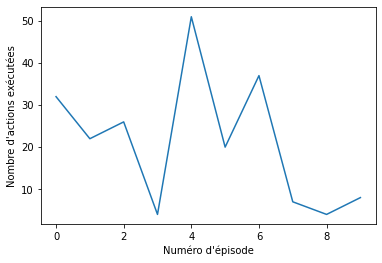

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

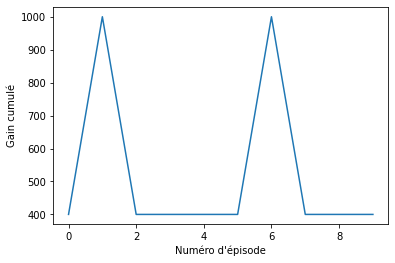

In [ ]:

plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

###Test 2: T= 50, epsilon_0= 0.5

####MC

In [ ]:
T= 50
epsilon_I= 0.5

In [ ]:
e= base.Maze()

In [ ]:
q,epi =monte_carlo(e, 0.9, 100)

In [ ]:
q

array([[127.83377523, 120.63737916, 279.68295606, 162.00169434],
       [184.55455802, 273.13824479, 338.5015556 , 251.50305907],
       [279.39374182, 276.5257326 , 400.        , 333.65793   ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ 98.35884648,  95.30756218, 143.0648459 , 156.45991869],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [236.196     ,   0.        , 293.22      , 314.867814  ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ 46.19912874,  31.90657723,  54.03406871, 117.81740983],
       [ 82.35645284,  63.37329046,   0.        ,  74.12080755],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ 35.45175248,   0.        ,   0.        ,  39.39083609],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0

In [ ]:
epi

[[[0, 2, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 1, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 3, 0.0, 4],
  [4, 2, 0.0, 4],
  [4, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 1, 0.0, 4],
  [4, 3, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 1, 0.0, 4],
  [4, 3, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 1, 0.0, 6],
  [6, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 1, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 2, 400.0, 3]],
 [[0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0

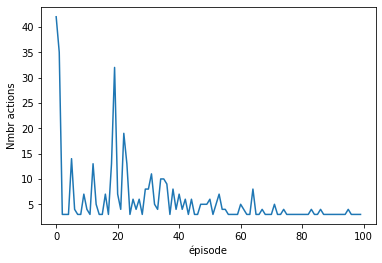

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))



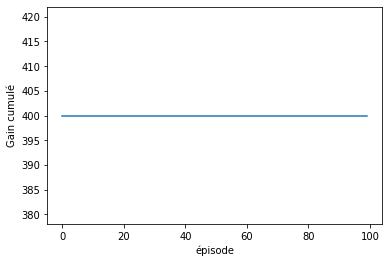

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))


> Nous avons eu un reward de valeur 400 pour tous les épisodes.

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

####SARSA

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 100)

In [ ]:
p= greedy_policy(q)

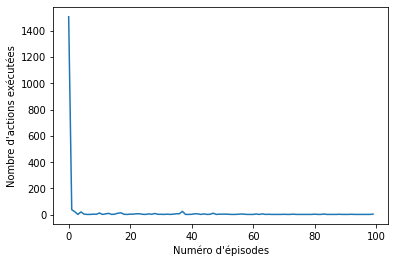

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

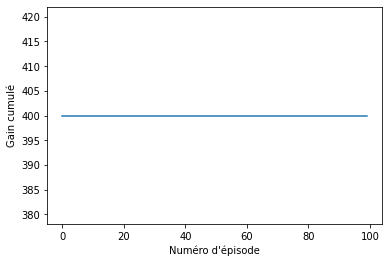

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

#### Q_Learning

In [ ]:
q, epi = qlearning(e,0.9, 0.1, 100)

In [ ]:
p= greedy_policy(q)

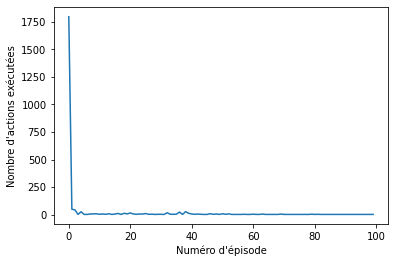

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

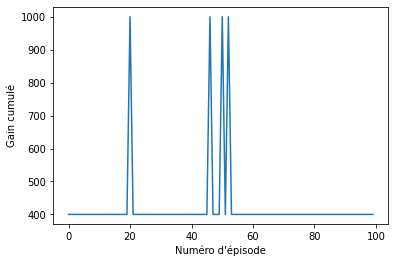

In [ ]:

plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

### Test3: T=1500, epsilon_0= 0.5

####MC

In [ ]:
T= 1500
epsilon_I= 0.5

In [ ]:
q,epi =monte_carlo(e, 0.9, 1000)

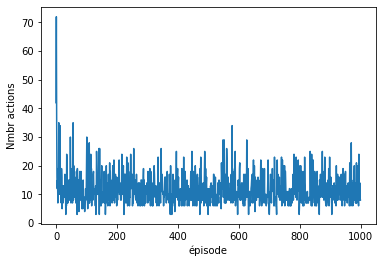

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))


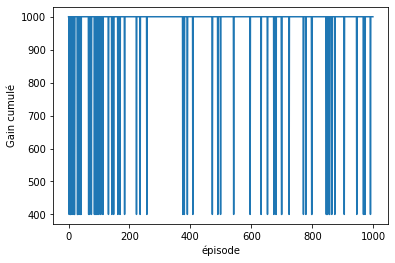

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ X _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ _ X _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ _ _ X ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ X F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 1000.0 is obtained
- Continuer (y/n) ? y

----- Terminal state ---

(6, 1000.0)

#### SARSA

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 1000)

In [ ]:
p= greedy_policy(q)

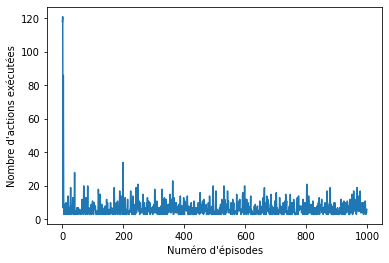

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

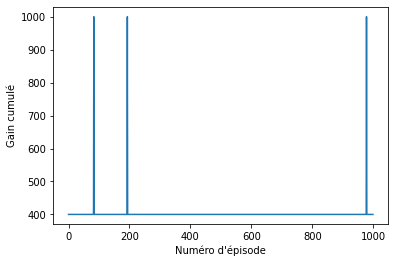

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

####Q_Learning

In [ ]:
q, epi = qlearning(e,0.9, 0.1, 1000)

In [ ]:
p= greedy_policy(q)

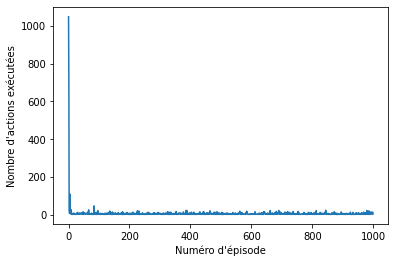

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

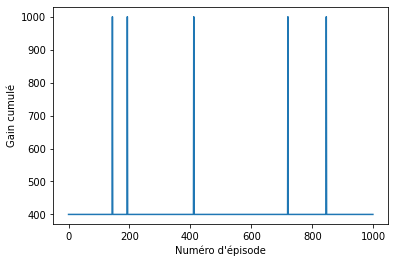

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

### Interprétation

> Nous  remaqruons, à travers les graphes, le nombre d'actions varie d'une manière aléatoire d'un épisode à un autre et cela pour les 3 tests et les 3 algorithmes.

> Nous remarquons que pour test1, test2 et test3 les 3 algos convergent mais pas vers la solution optimale (reward = 400).

> MC converge vers la solution optimale (reward = 1000) pour un T grand et un epsilon = 0.5.



##Question2

### a.Softmax

> Dans la section suivante, nous allons expliquer softmax dans les 3 algos avec des configurations différentes de T .

#### Test 1 : T= 0.5

In [ ]:
T= 0.5

##### MC

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 10)

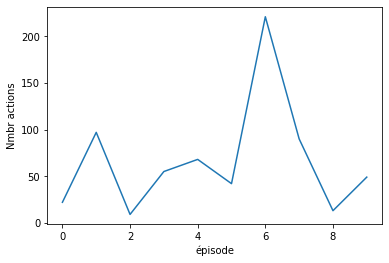

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))

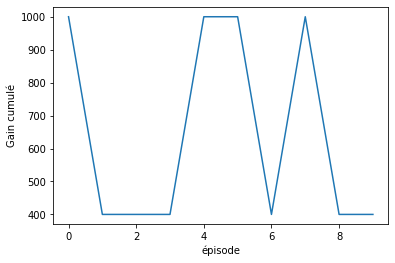

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

##### SARSA

In [ ]:
q_sarsa, epi_sarsa = sarsa_soft(e,0.9, 0.1, 10)

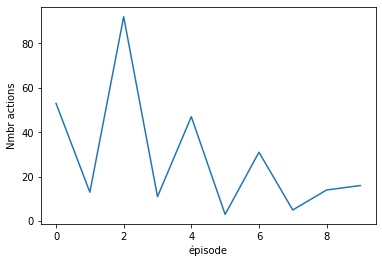

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi_sarsa))

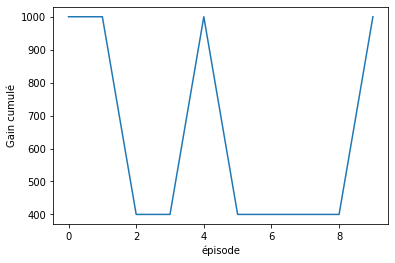

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi_sarsa))

In [ ]:
p= greedy_policy(q_sarsa)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

##### Q_Learning

In [ ]:
q_QL, epi_QL = qlearning_soft(e,0.9, 0.1, 10)

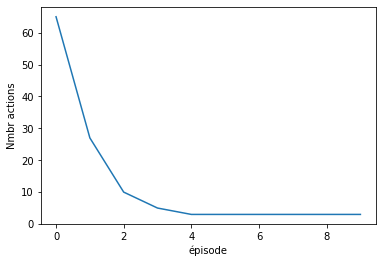

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi_QL))

> Nous remarquons que le nombre d'actions diminue en fonction du nombre d'épisodes.  

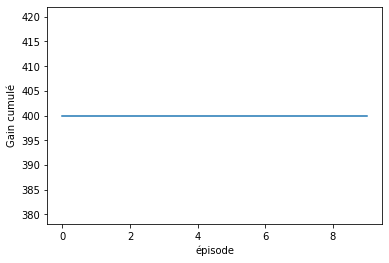

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi_QL))

In [ ]:
p= greedy_policy(q_QL)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

#### Test 2 : T= 50

In [ ]:
T= 50

##### MC

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 100)

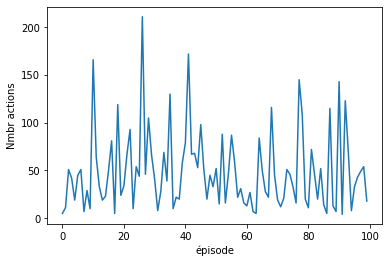

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))

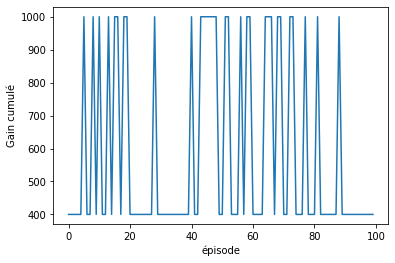

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

##### SARSA

In [ ]:
q_sarsa, epi_sarsa = sarsa_soft(e,0.9, 0.1, 100)

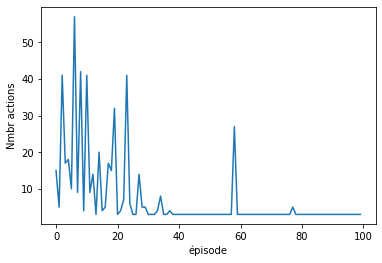

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi_sarsa))

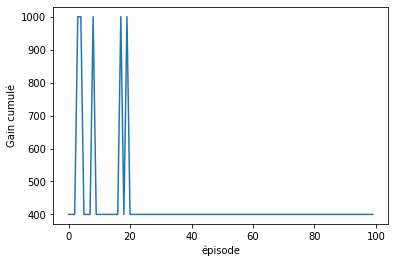

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi_sarsa))

> Nous remarquons qu'au début, nous obtenons le gain optimal, mais à partir de l'épisode 20, le gain obtenu  reste constent (400).

In [ ]:
p= greedy_policy(q_sarsa)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

##### Q_Learning


In [ ]:
q_QL, epi_QL = qlearning_soft(e,0.9, 0.1, 100)

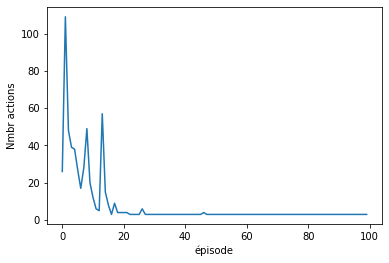

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi_QL))

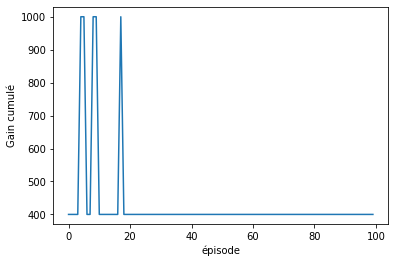

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi_QL))

In [ ]:
p= greedy_policy(q_QL)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

#### Test 3 : T= 1500

In [ ]:
T= 1500

##### MC

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 1000)

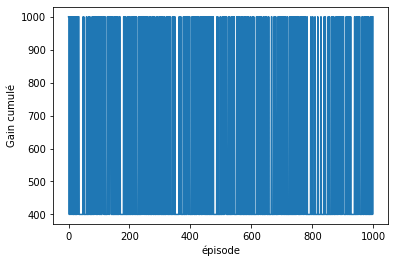

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

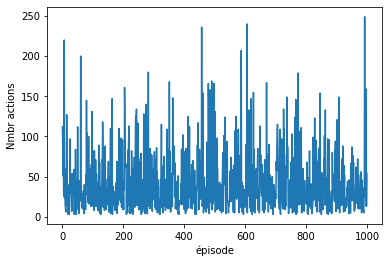

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

##### SARSA

In [ ]:
q_sarsa, epi_sarsa = sarsa_soft(e,0.9, 0.1, 1000)

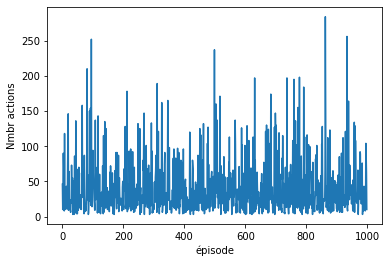

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi_sarsa))

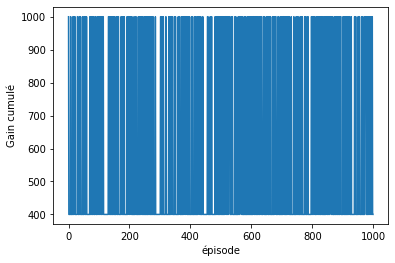

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi_sarsa))

In [ ]:
p= greedy_policy(q_sarsa)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ X G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 400.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
■ ■ ■ ■ ■ ■ 
■ A _ _ X ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 



(3, 400.0)

##### Q_Learning

In [ ]:
q_QL, epi_QL = qlearning_soft(e,0.9, 0.1, 1000)

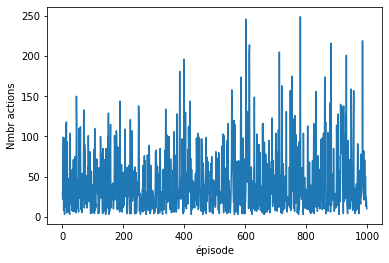

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi_QL))

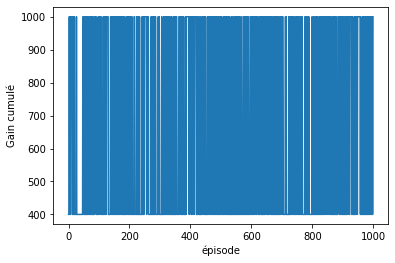

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi_QL))

In [ ]:
p= greedy_policy(q_QL)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ X _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ _ X _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ _ _ X ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ X F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 1000.0 is obtained
- Continuer (y/n) ? y

----- Terminal state ---

(6, 1000.0)

#### Interprétation

> Nous remaqruons, à travers les différents test, que le gain converge vers 400 (mais pas vers le gain optimal) pour les 3 algos avec les différentes configurations de T.

### b.Greedy avec une initialisation optimiste

> Dans cette section, nous allons appliquer Sarasa et Qlaerning en initialisant Q à Rmax / (1-gamma). Ensuite, nous appliquons la polotiques greedy.  

#### Sarsa

In [ ]:
q, epi = sarsa_greedy(e,0.9, 0.1, 10)

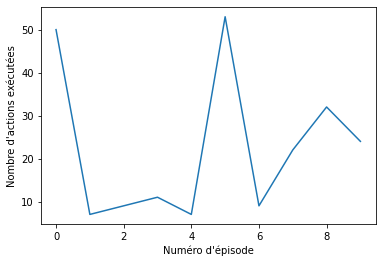

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))


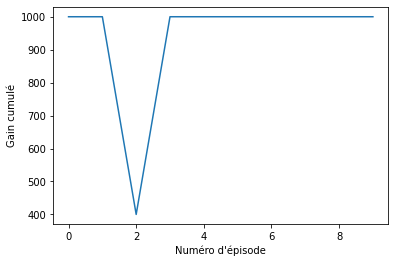

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
p

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
■ ■ ■ ■ 

(20, 0.0)

#### Q_Learning

In [ ]:
q, epi= qlearning_greedy(e,0.9, 0.1, 10)

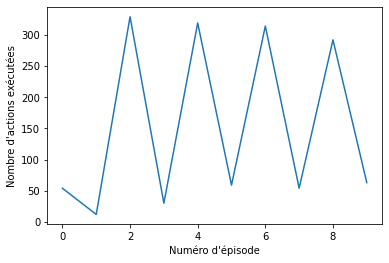

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

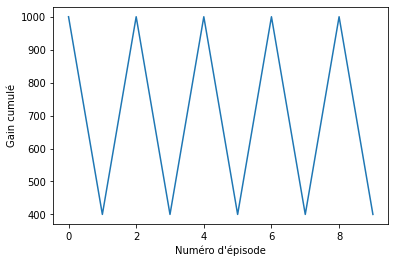

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ X ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ X _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ X _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ X _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
■ ■ ■ ■ ■ ■ 
■ A _ _ G ■
■ _ ■ _ ■ ■
■ X _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
■ ■ ■ ■ 

(20, 0.0)

In [ ]:
e.perform_episode(p, 500)

(500, 0.0)

In [ ]:
q, epi = qlearning_greedy(e,0.9, 0.1, 100)

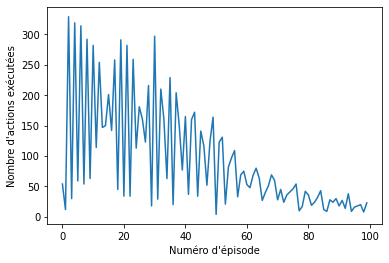

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

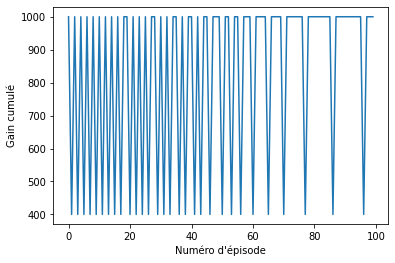

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
■ ■ ■ ■ ■ ■ 
■ X _ _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
■ ■ ■ ■ ■ ■ 
■ A X _ G ■
■ _ ■ _ ■ ■
■ _ _ _ ■ ■
■ _ ■ _ F ■
■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
■ ■ ■ ■ 

(50, 0.0)

In [ ]:
p= greedy_policy(q)
e.perform_episode(p, 500)

(500, 0.0)

In [ ]:
q, epi = qlearning_greedy(e,0.9, 0.1, 500)

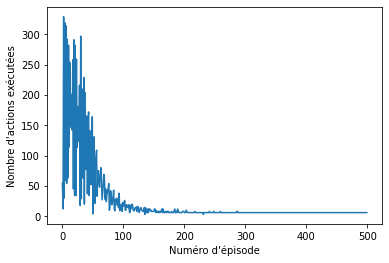

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

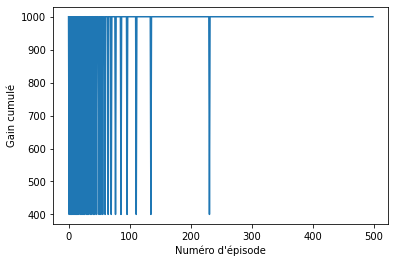

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

> Nous remarquons qu'avec l'envrionnement maze, plus le nombre d'épisode augmente plus le nombre d'action diminue.

> Quant au gain, les premiers épisodes, il alterne entre 400 et 1000 (la case finale est soit G/ F).

> A partir de 250 épisodes le gain est de 1000 (la case finale est toujours celle de F) pour un nombre d'épisode = 500.

#### Interprétation

> Nous remaqruons à travers les graphes obtenus que le gain cumulé est pratiquement = 1000 pour les 3 algos. Néanmoins, lors des tests en appliquant greedy pour la politque, les algos ne convergent pas (ni vers F, ni vers G).

##Question3

> Nous allons réexécuter les différents cas vu précédemment avec l'environnement  FrozenLake44 et FoorRooms_Key.

####Env FrozenLake44

#####Test 1: T=5, epsilon_0= 1

In [ ]:
T= 5
epsilon_I= 1

In [ ]:
e= base.FrozenLake44()

######MC

* egreedy

In [ ]:
q,epi =monte_carlo(e, 0.9, 10)

In [ ]:
q

array([[0.03169804, 0.        , 0.04842756, 0.04483009],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.1076168 , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.23914845, 0.729     ],
       [0.5937705 , 0.81      , 0.        , 0.        ],
       [0.        , 0.9       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.59049   , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
epi

[[[0, 2, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 1, 0.0, 1],
  [1, 3, 0.0, 0],
  [0, 0, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 0, 0.0, 12]],
 [[0, 1, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 3, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 0, 0.0, 5]],
 [[0, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 0, 0.0, 0],
  [0, 2, 0.0, 4],
  [4, 2, 0.0, 0],
  [0, 1, 0.0, 1],
  [1, 1, 0.0, 5]],
 [[0, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 4],
  [4, 2, 0.0, 8],
  [8, 2, 0.0, 9],
  [9, 0, 0.0, 13],
  [13, 2, 0.0, 9],
  [9, 0, 0.0, 8],
  [8, 3, 0.0, 9],
  [9, 1, 0.0, 10],
  [10, 1, 0.0, 14],
  [14, 1, 1.0, 15]],
 [[0, 1, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 1],
  [1, 0, 0.0, 1],
  [1, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 2, 0.0, 3],
  [3, 2, 0.0, 3],
  [3, 2, 0.0, 3],
  [3, 2, 0.0, 3],
  [3, 1, 0.0, 2],
  [2, 0, 0.0, 6],
  [6, 0, 0.0, 2],
  [2, 2, 0.0, 6],
  [6, 2, 0.0, 10],
  [10, 3, 0.0, 11]],
 [[0, 0, 0.0, 0],
  [0, 2, 0.0, 4],
  [4, 0, 0.0

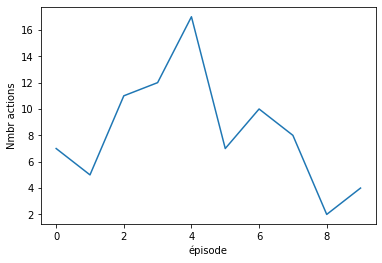

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))



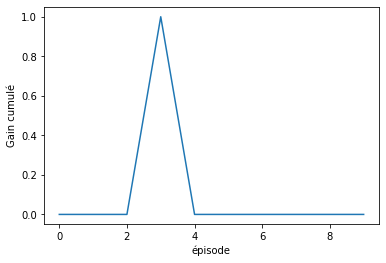

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))


In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
S _ _ _ 
_ X _ H 
_ _ _ H 
H _ _ G 



(3, 0.0)

 * b. softmax  








In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 10)

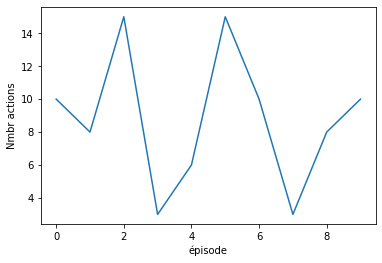

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))

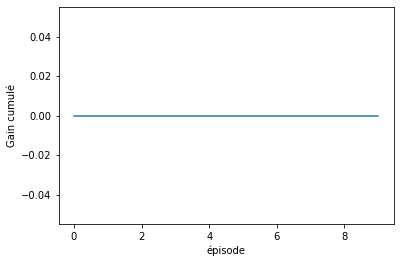

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,10)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
S _ _ _ 
_ H _ H 
_ _ _ H 
X _ _ G 



(3, 0.0)

######SARSA

* egreedy

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 10)

In [ ]:
p= greedy_policy(q)

In [ ]:
q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

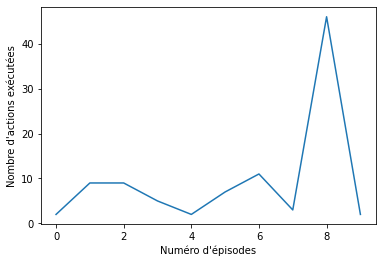

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

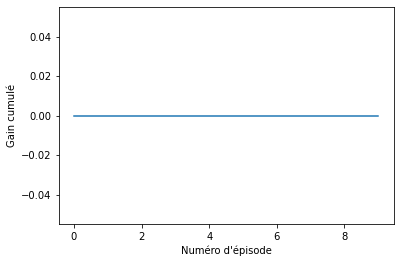

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 10)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
S _ _ _ 
_ H _ H 
_ _ _ H 
X _ _ G 



(5, 0.0)

* softmax

In [ ]:
q, epi = sarsa_soft(e,0.9, 0.1, 10)

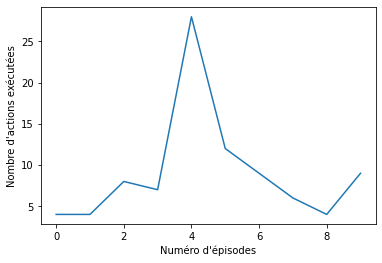

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

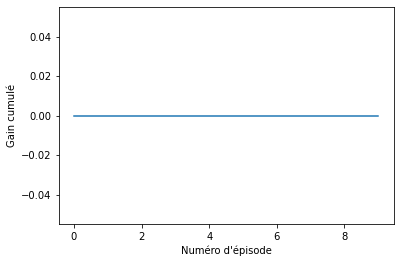

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(12, 0.0)

In [ ]:
e.perform_episode(p, 50)

(28, 0.0)

######Q_Learning

* egreedy

In [ ]:
q, epi_ = qlearning(e,0.9, 0.1, 10)

In [ ]:
p= greedy_policy(q)

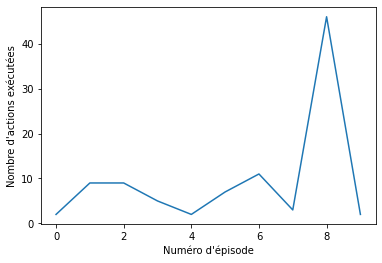

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

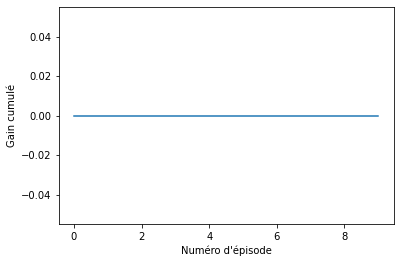

In [ ]:

plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 10)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(10, 0.0)

* softmax

In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 10)

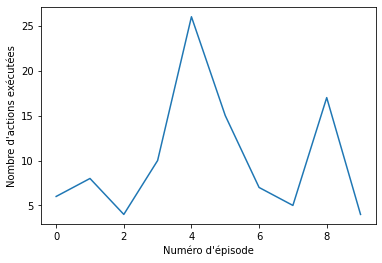

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

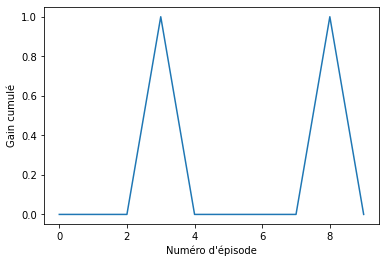

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 10)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- T

(8, 0.0)

#####Test 2: T= 50, epsilon_0= 0.5

In [ ]:
T= 50
epsilon_I= 0.5

######MC

* egreedy

In [ ]:
q,epi =monte_carlo(e, 0.9, 100)

In [ ]:
q

array([[0.00165403, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00649604, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.02209091, 0.        , 0.        ],
       [0.        , 0.        , 0.050625  , 0.        ],
       [0.1       , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
epi

[[[0, 1, 0.0, 4],
  [4, 2, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 1, 0.0, 2],
  [2, 2, 0.0, 3],
  [3, 2, 0.0, 3],
  [3, 1, 0.0, 3],
  [3, 2, 0.0, 7]],
 [[0, 0, 0.0, 0], [0, 1, 0.0, 1], [1, 0, 0.0, 5]],
 [[0, 0, 0.0, 0], [0, 0, 0.0, 4], [4, 1, 0.0, 5]],
 [[0, 0, 0.0, 4],
  [4, 2, 0.0, 0],
  [0, 0, 0.0, 4],
  [4, 0, 0.0, 4],
  [4, 0, 0.0, 4],
  [4, 0, 0.0, 4],
  [4, 1, 0.0, 4],
  [4, 0, 0.0, 8],
  [8, 0, 0.0, 8],
  [8, 0, 0.0, 12]],
 [[0, 3, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 0, 0.0, 2],
  [2, 0, 0.0, 6],
  [6, 0, 0.0, 10],
  [10, 0, 0.0, 6],
  [6, 0, 0.0, 10],
  [10, 0, 0.0, 6],
  [6, 0, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 0, 0.0, 5]],
 [[0, 0, 0.0, 0],
  [0, 2, 0.0, 4],
  [4, 0, 0.0, 8],
  [8, 0, 0.0, 8],
  [8, 2, 0.0, 4],
  [4, 2, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 4],
  [4, 2, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 4],
  [4, 1, 0.0, 8],
  [8, 0, 0.0, 4],
  [4, 2, 0.0, 0],
  [0, 1,

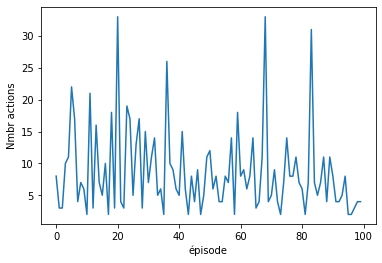

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))



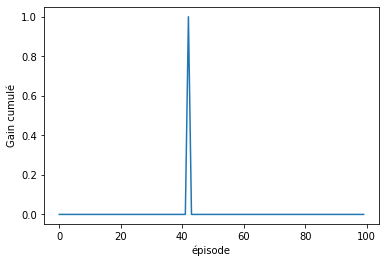

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))


In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(10, 0.0)

* softmax

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 100)

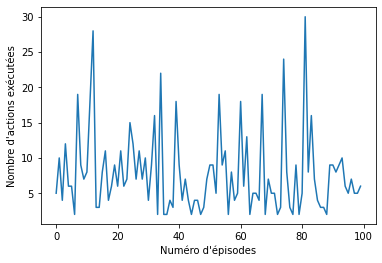

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

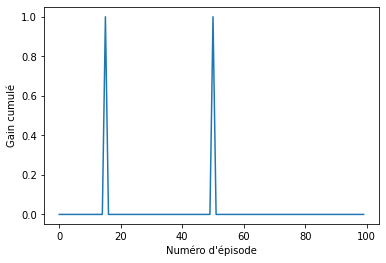

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(15, 0.0)

######SARSA

* egreedy

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 100)

In [ ]:
p= greedy_policy(q)

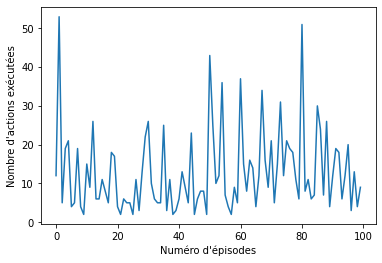

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

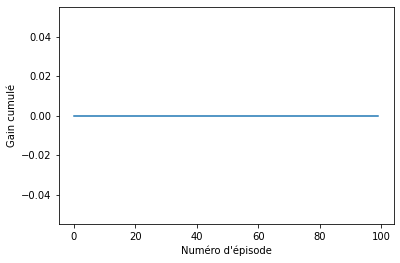

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 20)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(20, 0.0)

* softmax





In [ ]:
q, epi = sarsa_soft(e,0.9, 0.1, 100)

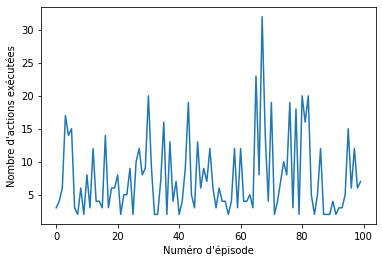

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

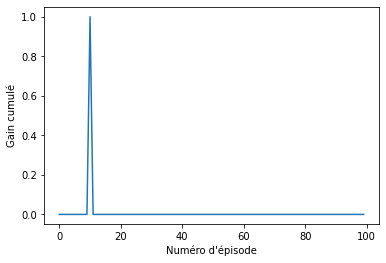

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- T

(8, 0.0)

###### Q_Learning

* egreedy

In [ ]:
q, epi = qlearning(e,0.9, 0.1, 100)

In [ ]:
p= greedy_policy(q)

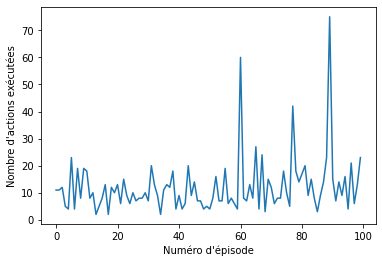

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

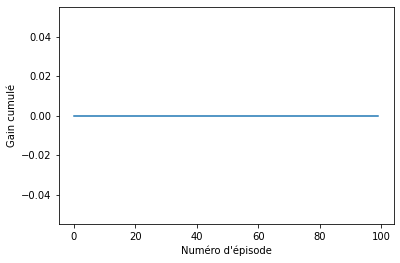

In [ ]:

plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 20)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(20, 0.0)

* softmax

In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 100)

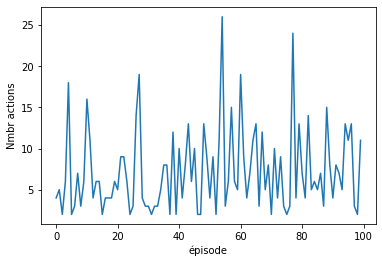

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))

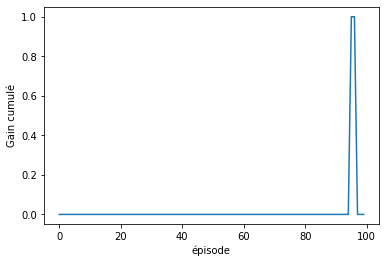

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(11, 0.0)

#####Test3: T=1500, epsilon_0= 0.5

In [ ]:
T= 1500
epsilon_I= 0.5

######MC

* egreedy

In [ ]:
q,epi =monte_carlo(e, 0.9, 1000)

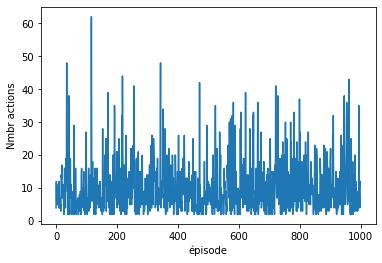

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))


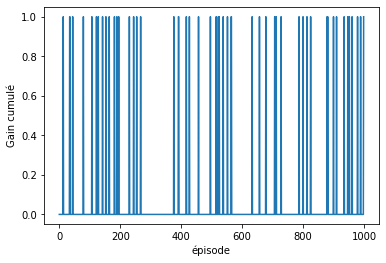

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(24, 0.0)

* softmax

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 1000)

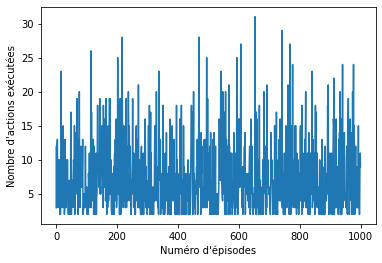

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

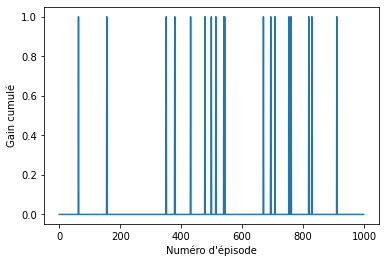

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 3 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(17, 0.0)

###### SARSA

* egreedy

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 1000)

In [ ]:
p= greedy_policy(q)

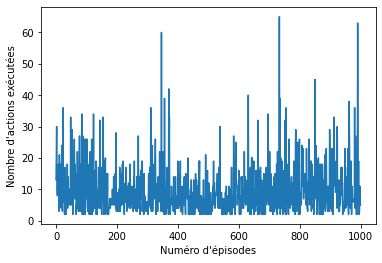

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

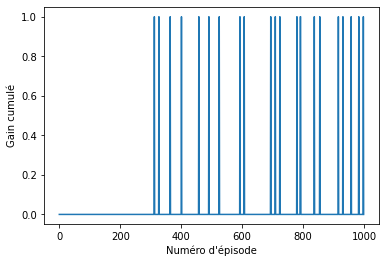

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
_ H _ H 
_ X _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
_ H _ H 
_ X _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
_ H _ H 
_ _ _ H 
H X _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(9, 1.0)

* softmax

In [ ]:
q, epi = sarsa_soft(e,0.9, 0.1, 1000)

In [ ]:
epi

[[[0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 0],
  [1, 0, 0.0, 1],
  [5, 1, 0.0, 5]],
 [[1, 1, 0.0, 1], [5, 0, 0.0, 5]],
 [[1, 2, 0.0, 1],
  [1, 3, 0.0, 1],
  [0, 1, 0.0, 0],
  [4, 1, 0.0, 4],
  [4, 1, 0.0, 4],
  [8, 0, 0.0, 8],
  [12, 2, 0.0, 12]],
 [[0, 3, 0.0, 0],
  [0, 2, 0.0, 0],
  [0, 2, 0.0, 0],
  [4, 2, 0.0, 4],
  [0, 2, 0.0, 0],
  [1, 2, 0.0, 1],
  [5, 3, 0.0, 5]],
 [[4, 2, 0.0, 4], [5, 0, 0.0, 5]],
 [[1, 0, 0.0, 1],
  [0, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [4, 0, 0.0, 4],
  [8, 2, 0.0, 8],
  [12, 1, 0.0, 12]],
 [[0, 1, 0.0, 0],
  [1, 3, 0.0, 1],
  [0, 1, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 2, 0.0, 0],
  [0, 1, 0.0, 0],
  [4, 2, 0.0, 4],
  [8, 1, 0.0, 8],
  [12, 1, 0.0, 12]],
 [[4, 1, 0.0, 4],
  [8, 2, 0.0, 8],
  [9, 1, 0.0, 9],
  [10, 1, 0.0, 10],
  [11, 0, 0.0, 11]],
 [[0, 2, 0.0, 0],
  [0, 1, 0.0, 0],
  [4, 0, 0.0, 4],
  [4, 3, 0.0, 4],
  [0, 3, 0.0, 0],
  [0, 1, 0.0, 0],
  [4, 3, 0.0, 4],
  [5, 3, 0.0, 5]],
 [[0, 3, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 2, 0.0,

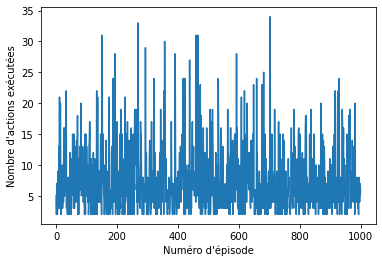

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

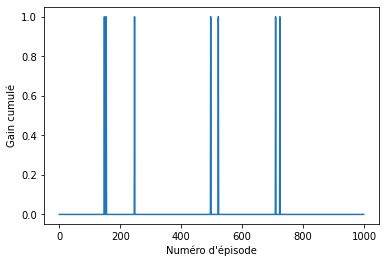

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
S _ _ _ 
_ H _ H 
_ _ _ H 
X _ _ G 



(4, 0.0)

######Q_Learning

* egreedy

In [ ]:
q, epi = qlearning(e,0.9, 0.1, 1000)

In [ ]:
p= greedy_policy(q)

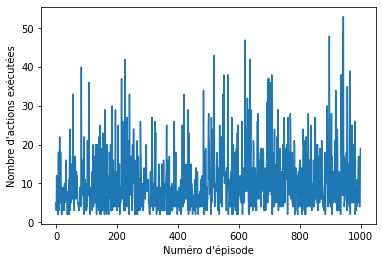

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

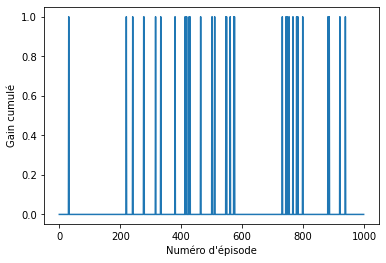

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
S _ _ _ 
_ H _ H 
X _ _ H 
H _ _ G 

Action 3 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 7 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- S

(35, 1.0)

* softmax

In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 1000)

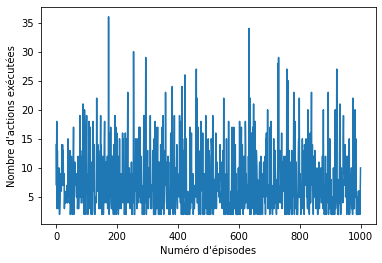

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

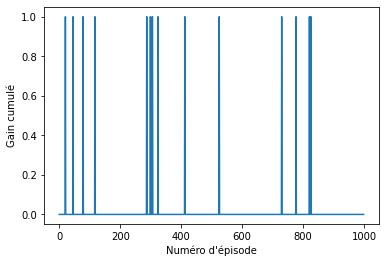

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 2 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 3 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 4 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 5 -----
X _ _ _ 
_ H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 6 -----
S _ _ _ 
X H _ H 
_ _ _ H 
H _ _ G 

Action 2 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Terminal state -----
S _ _ _ 
_ X _ H 
_ _ _ H 
H _ _ G 



(7, 0.0)

##### Initialisation Optimale

###### Sarsa

In [ ]:
q, epi = sarsa_greedy(e,0.9, 0.1, 10)

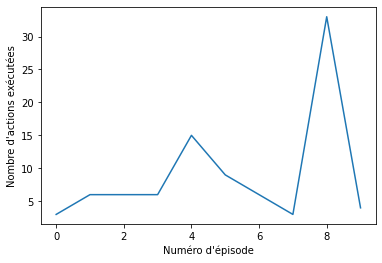

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

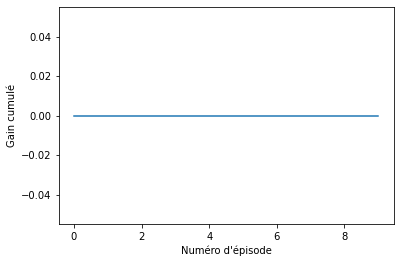

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.perform_episode(p, 500)

(2, 0.0)

###### Q_Learning

In [ ]:
q, epi_ = qlearning_greedy(e,0.9, 0.1, 100)

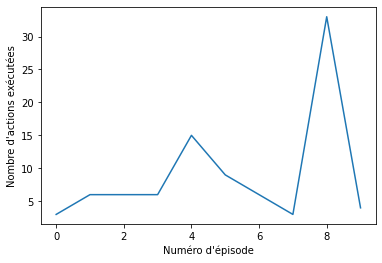

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))



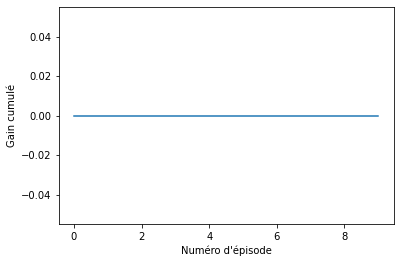

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
q, epi_ = qlearning_greedy(e,0.1, 0.1, 100)

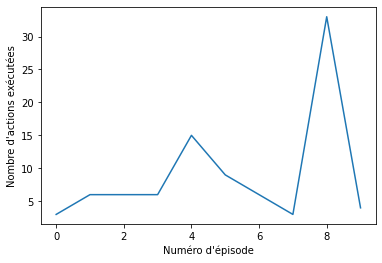

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

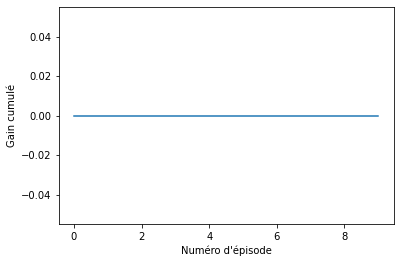

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

### Interprétation

> Nous avons obtenu le gain optimal (reward = 1000) en appliquant Sarsa et MC avec un nombre d'épisodes = 1000 avec egreedy et egreedy_decision.

> Pour les autres cas, nous avons obtenu un gain = 0.

###Env FoorRooms_Key

#####Test 1: T=5, epsilon_0= 1

In [ ]:
T= 5
epsilon_I= 1

In [ ]:
e= base.FoorRooms_Key()

######MC

* egreedy

In [ ]:
q,epi =monte_carlo(e, 0.9, 10)

In [ ]:
q

array([[6.09693791e-011, 5.74163771e-010, 2.26304513e-010,
        5.09776171e-012],
       [4.35326313e-010, 1.84247157e-011, 5.48950331e-011,
        2.62173716e-010],
       [6.89251833e-011, 1.56055046e-012, 8.10967733e-013,
        2.45101454e-012],
       [1.12182165e-012, 2.24263728e-013, 6.76732304e-013,
        4.59311147e-013],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [1.44852624e-008, 6.03227000e-008, 1.79420601e-008,
        2.38193776e-010],
       [3.84612127e-008, 1.13667668e-013, 1.32757258e-008,
        2.05194129e-010],
       [1.45972961e-008, 5.41492611e-010, 1.78702251e-012,
      

In [ ]:
epi

[[[10, 2, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 1, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 2, 0.0, 3],
  [3, 2, 0.0, 3],
  [3, 3, 0.0, 3],
  [3, 3, 0.0, 3],
  [3, 3, 0.0, 3],
  [3, 2, 0.0, 3],
  [3, 0, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 1, 0.0, 10],
  [10, 2, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 1, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 2, 0.0, 3],
  [3, 0, 0.0, 2],
  [2, 1, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 2, 0.0, 3],
  [3, 3, 0.0, 3],
  [3, 1, 0.0, 12],
  [12, 3, 0.0, 3],
  [3, 1, 0.0, 12],
  [12, 0, 0.0, 11],
  [11, 0, 0.0, 10],
  [10, 2, 0.0, 11],
  [11, 2, 0.0, 12],
  [12, 1, 0.0, 21],
  [21, 0, 0.0, 20],
  [20, 2, 0.0, 21],
  [21, 1, 0.0, 30],
  [30, 2, 0.0, 30],
  [30, 1, 0.0, 30],
  [30, 2, 0.0, 30],
  [30, 1, 0.0, 30],
  [30, 3, 0.0, 21],
  [21, 3, 0.0, 12],
  [12, 3, 0.0, 3],
  [3, 1, 0.0, 12],
  [12, 3, 0.0, 3],
  [3, 1, 0.0, 12],
  [12, 2, 0.0, 1

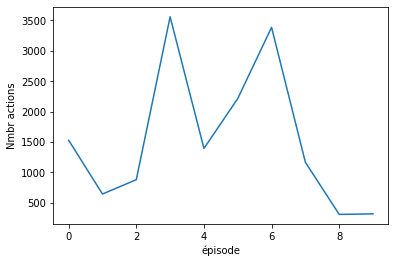

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))



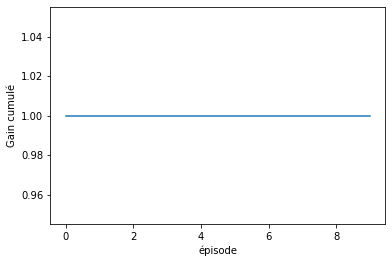

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))


In [ ]:
p= greedy_policy(q)
e.observe_episode(p,30)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ X A _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(30, 0.0)

* softmax

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 10)

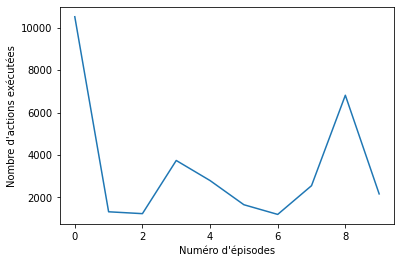

In [ ]:
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

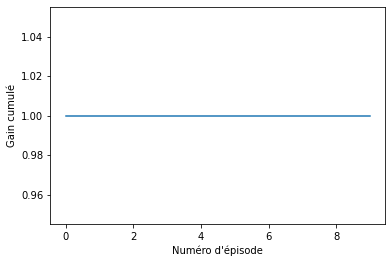

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p= greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(43, 0.0)

######SARSA

* egreedy

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 10)

In [ ]:
p= greedy_policy(q)

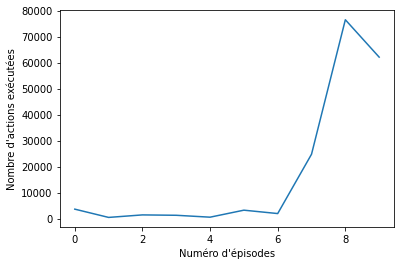

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

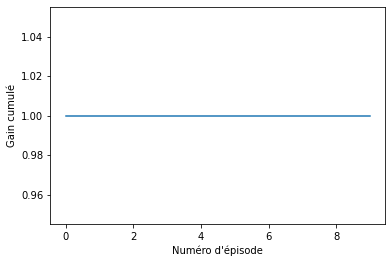

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ X A _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(10, 0.0)

* softmax

In [ ]:
q, epi = sarsa_soft(e,0.9, 0.1, 10)

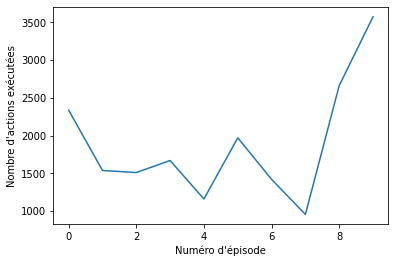

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

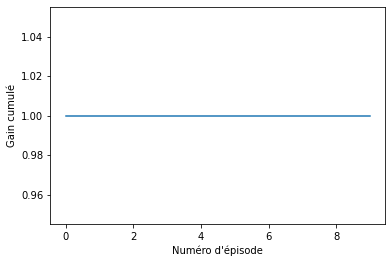

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

######Q_Learning

. egreedy

In [ ]:
q, epi_ = qlearning(e,0.9, 0.1, 10)

In [ ]:
p= greedy_policy(q)

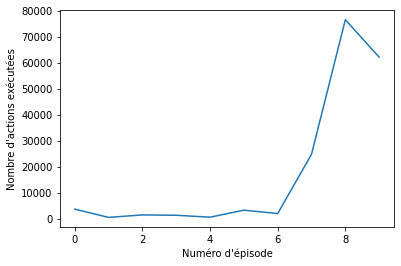

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

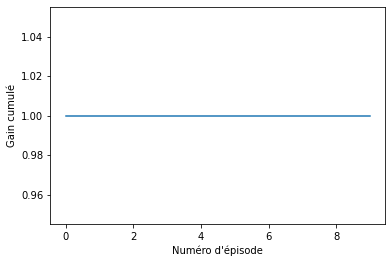

In [ ]:

plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 10)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 0 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ X A _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(10, 0.0)

* softmax


In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 10)

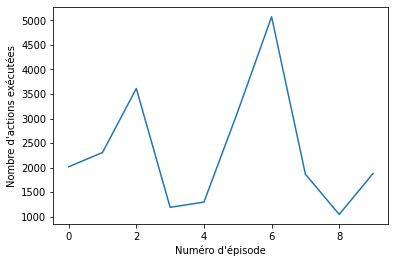

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

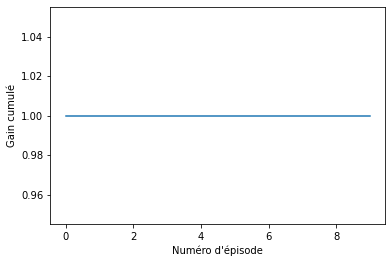

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

#####Test 2: T= 50, epsilon_0= 0.5

In [ ]:
T= 50
epsilon_I= 0.5

######MC

* egreedy

In [ ]:
q,epi =monte_carlo(e, 0.9, 100)

In [ ]:
q

array([[8.29397148e-06, 7.90639178e-04, 1.26742294e-04, 6.83562163e-05],
       [5.04460111e-04, 8.34923755e-05, 2.84476292e-04, 2.65625034e-04],
       [3.47803463e-04, 1.32188517e-04, 7.59571651e-05, 8.26091417e-06],
       [3.58352799e-05, 8.73298959e-05, 0.00000000e+00, 1.24251919e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48066478e-03, 4.49520124e-04, 1.50352455e-03, 5.35629661e-04],
       [2.33796498e-05, 1.14986652e-02, 9.95297151e-05, 2.85652629e-04],
       [8.47602003e-05, 1.07079477e-04, 9.03966150e-05, 1.47545491e-04],
       [7.95721241e-05, 8.77719007e-05, 2.99192903e-07, 1.76670417e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e

In [ ]:
epi

[[[10, 1, 0.0, 19],
  [19, 2, 0.0, 20],
  [20, 0, 0.0, 19],
  [19, 2, 0.0, 20],
  [20, 2, 0.0, 21],
  [21, 0, 0.0, 20],
  [20, 1, 0.0, 29],
  [29, 0, 0.0, 28],
  [28, 2, 0.0, 29],
  [29, 3, 0.0, 20],
  [20, 3, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 3, 0.0, 11],
  [11, 0, 0.0, 10],
  [10, 2, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 2, 0.0, 21],
  [21, 0, 0.0, 20],
  [20, 3, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 1, 0.0, 11],
  [11, 3, 0.0, 2],
  [2, 0, 0.0, 1],
  [1, 1, 0.0, 10],
  [10, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 2, 0.0, 10],
  [10, 0, 0.0, 9],
  [9, 3, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 1],
  [1, 3, 0.0, 1],
  [1, 2, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 3, 0.0, 2],
  [2, 1, 0.0, 11],
  [11, 2, 0.0, 12],
  [12, 1, 0.0, 21],
  [21, 2, 0.0, 21],
  [21, 3, 0.0, 12],
  [12, 1, 0.0, 21],
  [21, 0, 0.0, 20],
  [20, 3, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 2, 0.0, 21],
  [21, 1, 0.0, 30],
  [30, 0, 0.0, 29],
  [29, 0, 0.0, 28],
  [28, 3, 0.0, 19],
  [19, 0, 

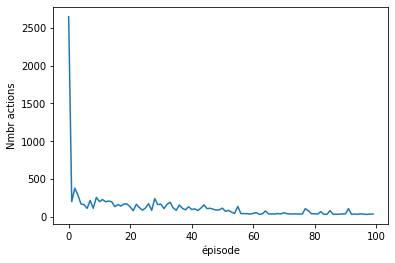

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))



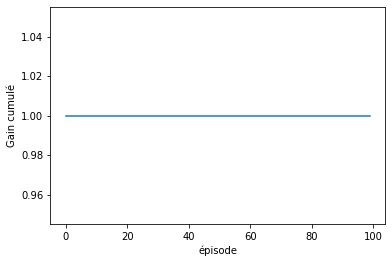

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))


In [ ]:
p= greedy_policy(q)
e.observe_episode(p,20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(20, 0.0)

* softmax

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 100)

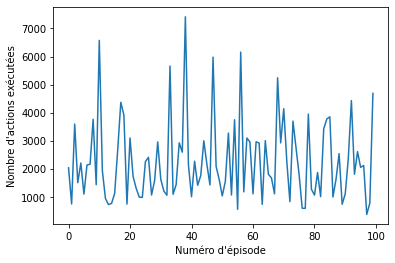

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

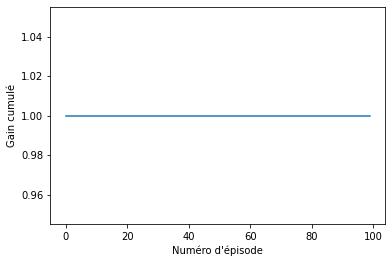

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

######SARSA

* egreedy

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 100)

In [ ]:
epi

[[[9, 1, 0.0, 9],
  [18, 0, 0.0, 18],
  [18, 0, 0.0, 18],
  [18, 2, 0.0, 18],
  [19, 1, 0.0, 19],
  [28, 2, 0.0, 28],
  [29, 2, 0.0, 29],
  [30, 0, 0.0, 30],
  [29, 3, 0.0, 29],
  [20, 2, 0.0, 20],
  [21, 0, 0.0, 21],
  [20, 0, 0.0, 20],
  [19, 2, 0.0, 19],
  [20, 0, 0.0, 20],
  [19, 3, 0.0, 19],
  [10, 3, 0.0, 10],
  [1, 3, 0.0, 1],
  [1, 0, 0.0, 1],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 0],
  [1, 1, 0.0, 1],
  [10, 0, 0.0, 10],
  [9, 0, 0.0, 9],
  [9, 1, 0.0, 9],
  [18, 3, 0.0, 18],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 3, 0.0, 9],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 2, 0.0, 0],
  [1, 0, 0.0, 1],
  [0, 0, 0.0, 0],
  [0, 0, 0.0, 0],
  [0, 3, 0.0, 0],
  [0, 2, 0.0, 0],
  [1, 0, 0.0, 1],
  [0, 0, 0.0, 0],
  [0, 1, 0.0, 0],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 2, 0.0, 9],
  [10, 0, 0.0, 10],
  [9, 0, 0

In [ ]:
p= greedy_policy(q)

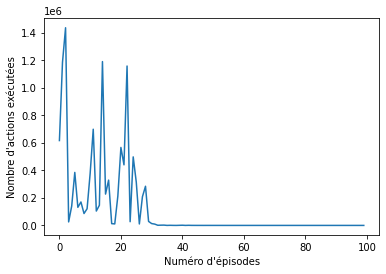

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

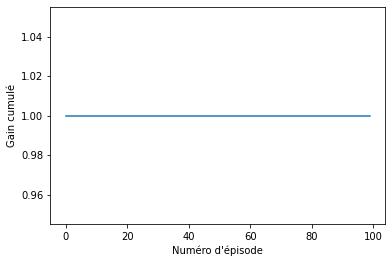

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 20)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(20, 0.0)

* softmax

In [ ]:
q, epi = sarsa_soft(e,0.9, 0.1, 100)

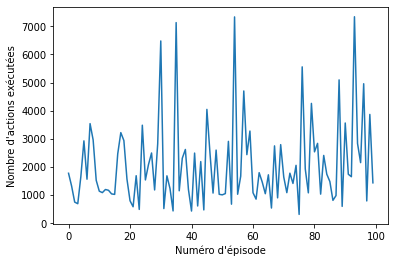

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

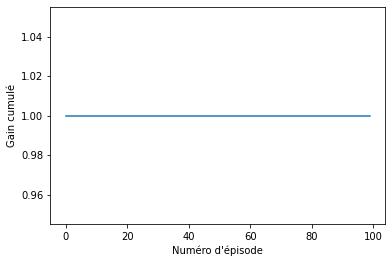

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

###### Q_Learning

* egreedy

In [ ]:
q, epi = qlearning(e,0.9, 0.1, 100)

In [ ]:
p= greedy_policy(q)

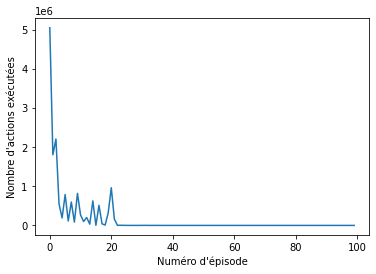

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

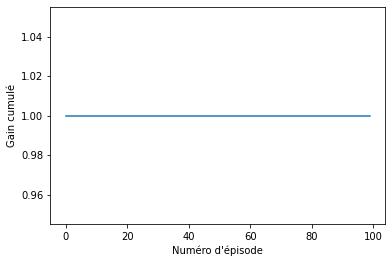

In [ ]:

plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 50)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(31, 1.0)

* softmax

In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 100)

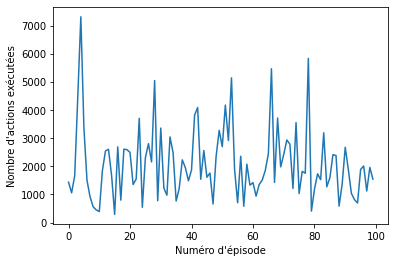

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))


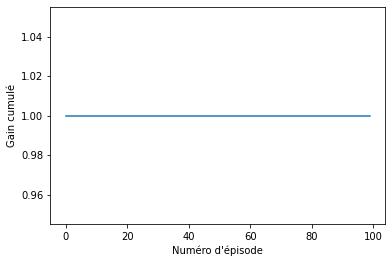

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

#####Test3: T=1500, epsilon_0= 0.5

In [ ]:
T= 1500
epsilon_I= 0.5

######MC

* egreedy

In [ ]:
q,epi =monte_carlo(e, 0.9, 1000)

In [ ]:
epi

[[[10, 0, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 1, 0.0, 18],
  [18, 2, 0.0, 19],
  [19, 1, 0.0, 28],
  [28, 2, 0.0, 29],
  [29, 0, 0.0, 28],
  [28, 3, 0.0, 19],
  [19, 3, 0.0, 10],
  [10, 1, 0.0, 19],
  [19, 2, 0.0, 20],
  [20, 2, 0.0, 21],
  [21, 2, 0.0, 21],
  [21, 0, 0.0, 20],
  [20, 0, 0.0, 19],
  [19, 0, 0.0, 18],
  [18, 3, 0.0, 9],
  [9, 0, 0.0, 9],
  [9, 2, 0.0, 10],
  [10, 2, 0.0, 11],
  [11, 0, 0.0, 10],
  [10, 2, 0.0, 11],
  [11, 0, 0.0, 10],
  [10, 2, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 0, 0.0, 19],
  [19, 1, 0.0, 28],
  [28, 2, 0.0, 29],
  [29, 0, 0.0, 28],
  [28, 3, 0.0, 19],
  [19, 1, 0.0, 28],
  [28, 2, 0.0, 29],
  [29, 1, 0.0, 29],
  [29, 1, 0.0, 29],
  [29, 3, 0.0, 20],
  [20, 3, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 3, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 2, 0.0, 21],
  [21, 3, 0.0, 12],
  [12, 0, 0.0, 11],
  [11, 1, 0.0, 20],
  [20, 0, 0.0, 19],
  [19, 1, 0.0, 28],
  [28, 0, 0.0, 27],
  [27, 3, 0.0, 18],
  [18, 0, 0.0, 18],
  [18, 0, 0.0, 18],
  [18, 1, 0.0, 27],
  [27, 3

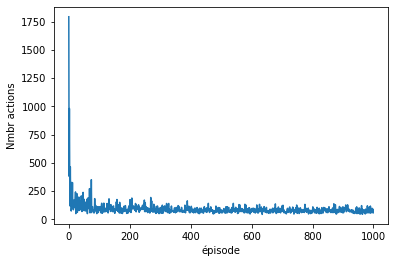

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Nmbr actions")
plt.plot(calculer_actions(epi))


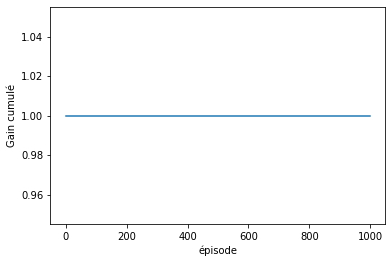

In [ ]:
plt.xlabel("épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p,50)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(33, 1.0)

* softmax

In [ ]:
q,epi =monte_carlo_soft(e, 0.9, 1000)

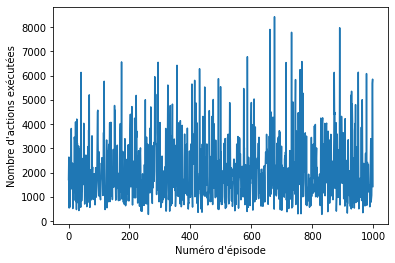

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))


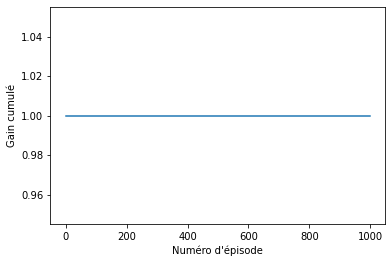

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

###### SARSA

* egreedy

In [ ]:
q, epi = sarsa(e,0.9, 0.1, 1000)

In [ ]:
p= greedy_policy(q)

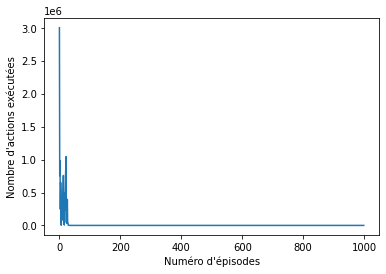

In [ ]:
####### Les graphes
plt.xlabel("Numéro d'épisodes")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

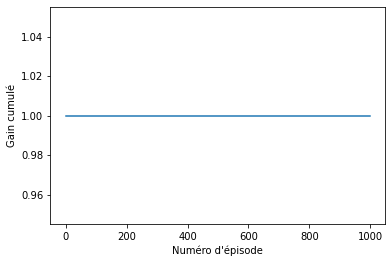

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
e.observe_episode(p, 50)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(31, 1.0)

* softmax

In [ ]:
q, epi = sarsa_soft(e,0.9, 0.1, 1000)

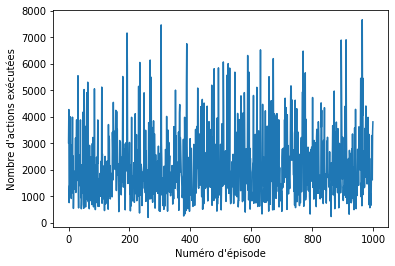

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))


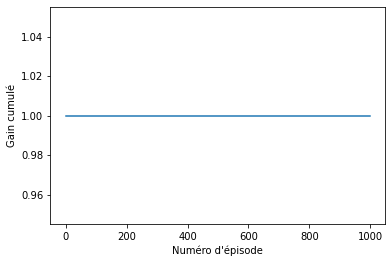

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

######Q_Learning

* egreedy

In [ ]:
q, epi = qlearning(e,0.9, 0.1, 1000)

In [ ]:
p= greedy_policy(q)

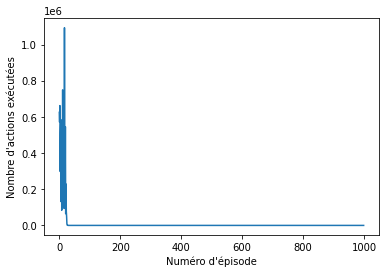

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

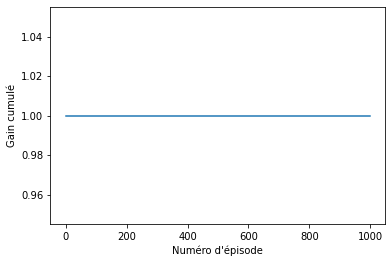

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
p=greedy_policy(q)
e.observe_episode(p, 50)


----- Step 0 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ X _ _ C _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 

Action 1 is performed
Reward 0.0 is obtained
- Continuer (y/n) ? y

----- Step 1 -----
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
■ _ _ _ _ ■ _ _ _ _ ■
■ _ A _ _ C _ _ _ _ ■
■ _ X _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ K _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _ ■ _ _ G _ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ ■ _ ■ ■ ■ ■ ■ ■ ■ ■
■ _ _ _ _ ■ _ _ _ _ ■
■ _ _ _ _ ■ _ T _ _ ■
■ _ _ _ _ _ _ _ _ _ ■
■ _ _ _ _

(31, 1.0)

* softmax

In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 1000) ## 4 min execution

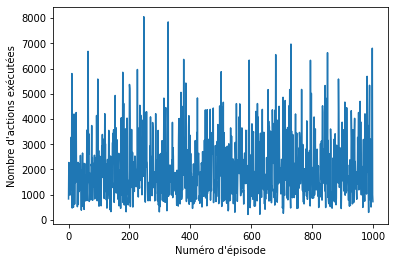

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

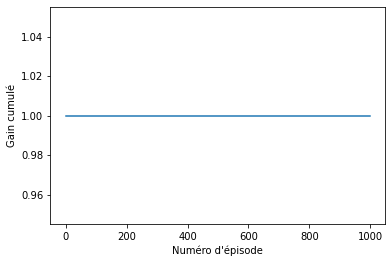

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

##### Softmax avec T = 0.5

###### Q_Learning

Ce test a été rajouté pour voir le temps dexécution lorsque T se rapproche de 0

In [ ]:
T= 0.5

In [ ]:
q, epi = qlearning_soft(e,0.9, 0.1, 1000) #2 min d'excution

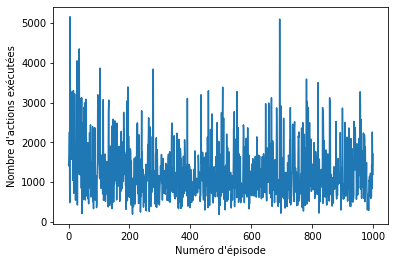

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

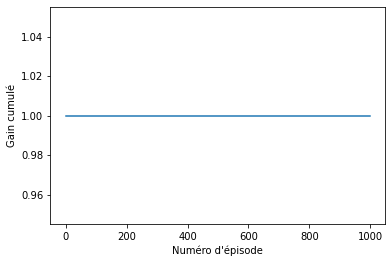

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

##### Initialisation Optimale

###### Sarsa

In [ ]:
q, epi = sarsa_greedy(e,0.9, 0.1, 10)

Sarsa avec l'environnement FoorRooms_Key prend plus de temps que sur les deux autre environnements avec le même nombre d'épisodes.

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

###### Q_Learning

In [ ]:
q, epi = qlearning_greedy(e,0.9, 0.1, 100)

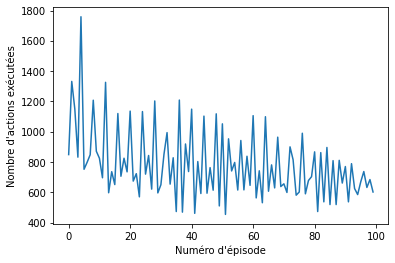

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

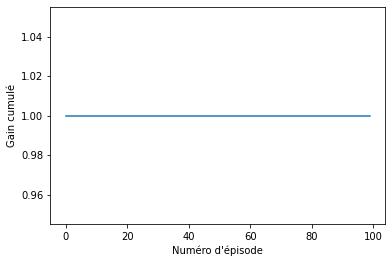

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
q, epi = qlearning_greedy(e,0.9, 0.1, 500)

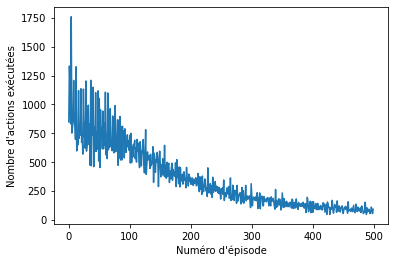

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

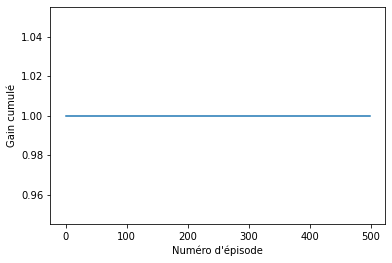

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

In [ ]:
q, epi = qlearning_greedy(e,0.1, 0.1, 500)

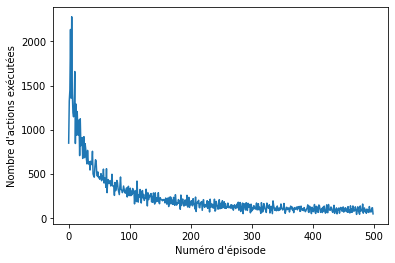

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Nombre d'actions exécutées")
plt.plot(calculer_actions(epi))

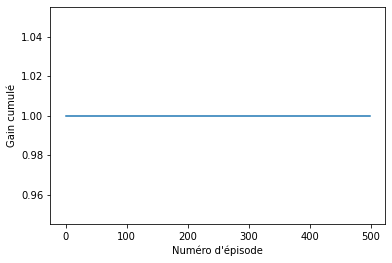

In [ ]:
plt.xlabel("Numéro d'épisode")
plt.ylabel("Gain cumulé")
plt.plot(calculer_gain_total(epi))

#### Interprétation
> Nous constatons que le gain cumulé converge toujours vers la solution optimal (1), pour les tous les algorithmes et tous les paramètres.

## Conclusion :
>Nous pouvons conclure à travers ce travail que le convergence vers la solution optimale dépend des paramètres et des différentes exploitations adoptées.  